In [1]:
import numpy as np
import pandas as pd
from graphviz import Source
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
iris = load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
X = iris.data
y = iris.target
X_petal = X[:, [2,3]]

<h3>Training a decision tree classifier</h3>

In [5]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_petal, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

<h3>Visualizing the trained decision tree</h3>

In [6]:
export_graphviz(decision_tree=tree_clf,
                out_file='iris_tree.dot',
                feature_names=['petal length (cm)', 'petal width (cm)'],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

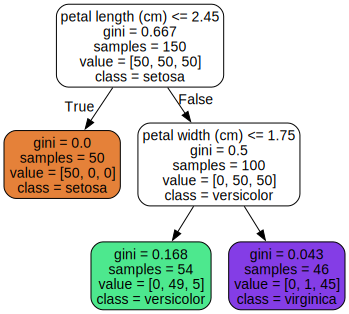

In [7]:
Source.from_file('iris_tree.dot')

In [8]:
iris.target_names.tolist()

['setosa', 'versicolor', 'virginica']

A node's
- `samples` attribute counts how many training instances it applies to.
    - For example, 100 training instances have petal length greater than 2.45.
    
&ensp;

- `value` attribute tells you how many training instances of each class this node applies to.
    - For example, the depth-2 right leaf node applies to 0 setosa, 1 versicolor, and 45 virginica.

&ensp;


- `gini` attribute measures its *Gini impurity*; a node is "pure" ($\text{gini} = 0$) if all training instances it applies to belong to the same class. 
    - For example, since the depth-1 left node applies only to *iris setosa* training instances, it is pure and its Gini impurity is 0.
    - Gini impurity $\, G_i \,$ of the *i*th node is calculated as $\, G_i = 1 - \sum_{k=1}^{K} p_{ik}^2, \,$ where $\, p_{ik} \,$ is the ratio of the class k instances among the training instances in the *i*th node.

In [9]:
def gini_impurity(value: list[int]):
    return np.round(1 - np.sum((value / np.sum(value))**2), 3).item()

In [10]:
gini_impurity([50,0,0])

0.0

In [11]:
gini_impurity([0,49,5])

0.168

In [12]:
gini_impurity([0,1,45])

0.043

<h3>Decision Boundary</h3>

In [15]:
def plot_decision_boundary(X, y, clf):
    # Create a meshgrid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5    # X1 (feature 1)
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5    # X2 (feature 2)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Predict class label for each grid point
    Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Accent)
    
    # Define markers, colors, and labels for each class
    markers = ['o', 's', '^'] 
    colors = ['red', 'blue', 'green']
    class_labels = np.unique(y)        # 0, 1, 2
    class_names = iris.target_names    # 'setosa', 'versicolor', 'virgincia'
    
    # Plot the original data (each class with a different marker)
    for i, label in enumerate(class_labels):
        X_sub = X[y == label]
        plt.scatter(X_sub[:,0], X_sub[:,1], marker=markers[i], color=colors[i], label=class_names[i])
    plt.xlabel('Petal length (cm)')
    plt.ylabel('Petal width (cm)')
    plt.legend();

- `np.meshgrid()` $\, \boldsymbol{\rightarrow} \,$ [illustration](https://github.com/HerraKaava/machine_learning/blob/main/decision_trees/mesh_grid.ipynb)

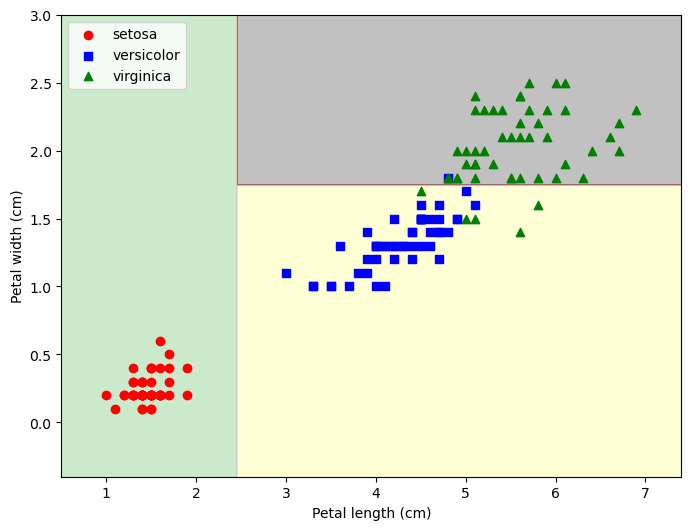

In [16]:
plot_decision_boundary(X_petal, y, tree_clf)

<h3>Estimating class probabilities</h3>

A decision tree can also estimate the probability that an instance belongs to a particular class *k*. Suppose that you have a flower whose petals are 5 cm long and 1.5 cm wide. Then, this instance would traverse to the depth-2 left node. The probability distribution of the *k* classes for this instance is the ratio of the respective class relative to all the training instances in the leaf node.

In [22]:
# An instance whose petal length is 5 cm and petal width is 1.5 cm
x_new = np.array([5.0, 1.5])[np.newaxis, :]
y_pred = tree_clf.predict_proba(x_new)
np.round(y_pred, 3)

array([[0.   , 0.907, 0.093]])

Let's see if this probability distribution makes sense. The depth-2 left node has 54 training instances such that there is 0 setosa, 49 versicolor, and 5 virginica.

$$ P(y_i = \text{setosa}) = \frac{0}{54} = 0 $$

$$ P(y_i = \text{versicolor}) = \frac{49}{54} = 0.907 $$

$$ P(y_i = \text{virginica}) = \frac{5}{54} = 0.093 $$

Makes sense, right? This applies to all the instances that traverse to this node. In other words, the same probability distribution is given for every instance that gets assigned to this leaf node. The class prediction is simply the maximum probability. In this case, all new instances that traverse to this node gets assigned to the *versicolor* class.